In [32]:
import re
import random
import pandas as pd
import hashlib

In [33]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [34]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Terraform,35.559489,17.779745,18.023587,2
OAuth 2.0 RFC6749,118.726352,14.840794,37.678639,8
Azure Functions + PP365,160.420412,32.084082,49.714182,5
CCH Tax Forms Project,413.672570,19.698694,85.348203,21
pfSense,421.808206,35.150684,127.731919,12
Accounting,514.786950,30.281585,86.959343,17
Python + Oauth2.0,660.533613,28.718853,98.925841,23
Active Directory and Azure Files,786.386493,21.253689,65.469945,37
FSLogix,826.241740,68.853478,156.395644,12
"The Starless Crown, Rollins",945.354802,35.013141,114.232567,27


# Histogram

sum of ages: ~44077.95


<Axes: >

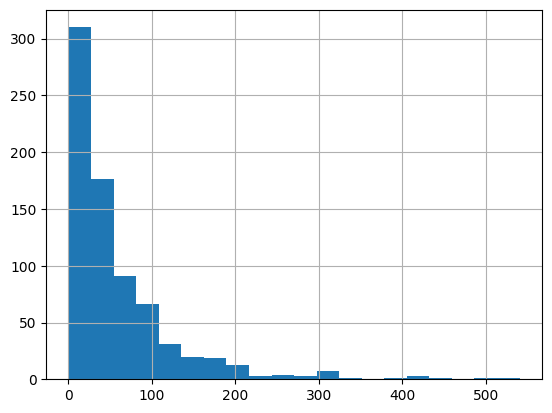

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~44077.95


<Axes: >

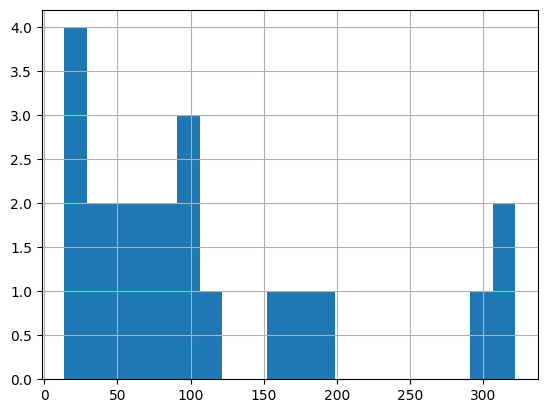

In [36]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [37]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [38]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 751
Total card age: 44077.95


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
13,C# Basics,Events use delegates to provide a way for a cl...,100ad5855cfede73f888d3e9485c7b26,540.635163,110.808196,540.635163,2326.972124,0.954288,21
14,C# Basics,Lambda expressions provide a concise way to re...,059a0c05a32a63a831c1c5515f10e488,486.610678,110.808196,540.635163,2326.972124,0.954288,21
65,Vocab,"Well of Lost Plots, Fforde\nInsouciance\nnoun ...",ae15401d43ed91aa235054578c87ffd1,455.051035,94.200093,455.051035,4144.804096,0.352874,44
61,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,421.800655,82.301924,421.800655,3127.473106,0.728465,38
85,Python,Q:\nWhat does the .with_suffix(new_suffix) met...,21ca55fe0eb03e620bb7df636fd19618,414.039664,50.961578,414.039664,3669.233645,0.405367,72
25,Asynchronous Python,Blocking Code\nCode like time.sleep() that hal...,86b1b1b8d6f8d43714c7e33ba4510bda,412.822174,76.203712,412.822174,1752.685380,0.386068,23
66,Vocab,"Red Side Story, FForde\nOsculation\nPronunciat...",c0228d8d87eacb74c922d616f38c5d9b,402.623520,94.200093,455.051035,4144.804096,0.352874,44
62,PnP PowerShell,Delegated Permissions\nPermissions granted to ...,53d0d302c9f3f7d4b92f4b022a587641,332.238808,82.301924,421.800655,3127.473106,0.728465,38
21,VMWare,Storage vMotion\n\nThe ability to migrate virt...,2e3e71c9de5d2efac881521e2e5b348d,322.022162,110.789913,322.022162,2437.378088,0.202508,22
81,JavaScript Concepts,Dot Notation: You can add a new key-value pair...,a0ed83f05c90c0e6ef142f108806685c,321.812601,62.437197,321.812601,3933.543425,0.297432,63


# N-fold shuffle


## Age Sum

In [39]:
# n = 5
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [40]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [41]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [42]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [43]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [44]:
existing_cards.head(10)['age'].sum()

np.float64(4109.656460093122)

In [45]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
13,C# Basics,Events use delegates to provide a way for a cl...,100ad5855cfede73f888d3e9485c7b26,540.635163,110.808196,540.635163,2326.972124,0.954288,21
14,C# Basics,Lambda expressions provide a concise way to re...,059a0c05a32a63a831c1c5515f10e488,486.610678,110.808196,540.635163,2326.972124,0.954288,21
65,Vocab,"Well of Lost Plots, Fforde\nInsouciance\nnoun ...",ae15401d43ed91aa235054578c87ffd1,455.051035,94.200093,455.051035,4144.804096,0.352874,44
61,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,421.800655,82.301924,421.800655,3127.473106,0.728465,38
85,Python,Q:\nWhat does the .with_suffix(new_suffix) met...,21ca55fe0eb03e620bb7df636fd19618,414.039664,50.961578,414.039664,3669.233645,0.405367,72
25,Asynchronous Python,Blocking Code\nCode like time.sleep() that hal...,86b1b1b8d6f8d43714c7e33ba4510bda,412.822174,76.203712,412.822174,1752.685380,0.386068,23
66,Vocab,"Red Side Story, FForde\nOsculation\nPronunciat...",c0228d8d87eacb74c922d616f38c5d9b,402.623520,94.200093,455.051035,4144.804096,0.352874,44
62,PnP PowerShell,Delegated Permissions\nPermissions granted to ...,53d0d302c9f3f7d4b92f4b022a587641,332.238808,82.301924,421.800655,3127.473106,0.728465,38
21,VMWare,Storage vMotion\n\nThe ability to migrate virt...,2e3e71c9de5d2efac881521e2e5b348d,322.022162,110.789913,322.022162,2437.378088,0.202508,22
81,JavaScript Concepts,Dot Notation: You can add a new key-value pair...,a0ed83f05c90c0e6ef142f108806685c,321.812601,62.437197,321.812601,3933.543425,0.297432,63


In [46]:
existing_cards['age'].mean()

np.float64(58.69234911918494)